In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score

In [7]:
df = pd.DataFrame()

# Combine the dataframes
for filename in listdir("dataset\\dataset\\train\\boxes_transcripts_labels\\"):
    df_temp = pd.read_csv("dataset\\dataset\\train\\boxes_transcripts_labels\\" + filename, sep = ",", header = None)
    df_temp.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right','transcript','field']
    #df_temp_trimmed = df_temp.loc[df_temp['field'] != 'OTHER']

    df = pd.concat([df, df_temp], ignore_index = True)

In [13]:
# Now we build the model and the preprocessing functions based on our analysis
def Feature_Engineering(df):
    df['x_center'] = df[['x_top_left', 'x_bottom_right']].mean(axis=1)
    df['y_center'] = df[['y_top_left', 'y_bottom_right']].mean(axis=1)
    df['index_len'] = df['end_index'] - df['start_index']

    # We select 5 features told to us by RFECV and the label
    df = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len', 'field']]

    return df

def X_y_split(df):
    y = df[['field']]
    X = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len']]
    return X,y

def Hierarchical_Training(df):
    df1 = Feature_Engineering(df)
    df2 = df1.copy()

    # For 1st model, we convert relevant columns as "not other"  & We reduce the number of "OTHER" columns to reduce skewness
    df1.loc[df["field"] != "OTHER", "field"] = 'NOT_OTHER'
    rus = RandomUnderSampler(random_state=0, sampling_strategy=0.5)
    X1,y1 = X_y_split(df1)
    resampled_X1, resampled_y1 = rus.fit_resample(X1,y1)
    X_train1, X_valid1, y_train1, y_valid1 = train_test_split(resampled_X1, resampled_y1, test_size = 0.2)





    # For 2nd model, we simply drop all rows with 'OTHER' as label
    df2 = df2.loc[df2['field'] != 'OTHER']
    X2,y2 = X_y_split(df2)
    X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y2, test_size = 0.2)

    return X_train1, X_valid1, y_train1, y_valid1, X_train2, X_valid2, y_train2, y_valid2


def Cross_Validation(X,y, model):

    # Create StratifiedKFold object.
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    accu_stratified = []
    
    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.values[train_index], X.values[test_index]
        y_train_fold, y_test_fold = y.values[train_index], y.values[test_index]
        model.fit(X_train_fold, y_train_fold.ravel())
        accu_stratified.append(model.score(X_test_fold, y_test_fold))
    
    return(accu_stratified)

In [34]:
#  Total training
cm_arr = []
X_train1, X_valid1, y_train1, y_valid1, X_train2, X_valid2, y_train2, y_valid2 = Hierarchical_Training(df)
for i in [100,150,200,250,300]:
        model1 = RandomForestClassifier(n_estimators = i)
        model2 = RandomForestClassifier(n_estimators = i)

        model1 = model1.fit(X_train1, y_train1.values.ravel())
        model2 = model2.fit(X_train2, y_train2.values.ravel())

        y_pred1 = model1.predict(X_valid1)
        y_pred2 = model2.predict(X_valid2)

        print('current iteration: ',i)

        acc_other = accuracy_score(y_valid1, y_pred1)
        acc_fine = accuracy_score(y_valid2, y_pred2)

        cm_arr.append([i, acc_other, acc_fine])
        
        

current iteration:  100
current iteration:  150
current iteration:  200
current iteration:  250
current iteration:  300


In [37]:
cm_arr
x = []
acc_ot = []
acc_fi = []

for i in range(len(cm_arr)):
    x.append(cm_arr[i][0])
    acc_ot.append(cm_arr[i][1])
    acc_fi.append(cm_arr[i][2])

# cm_plot = cm_arr[1][0]
# sns.heatmap(cm_plot/np.sum(cm_plot), annot=True, fmt='.2%')
# cm_plot

[0.9628359694724035, 0.9632783984072558, 0.9629465767061166, 0.9631677911735428, 0.9613980754341334]


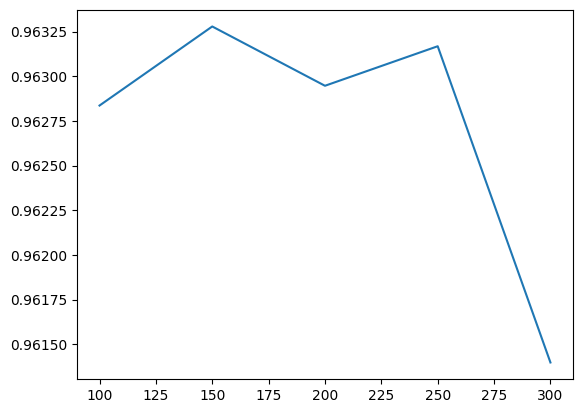

In [41]:
print(acc_ot)
plt.plot(x,acc_ot)

[0.9459190444591904, 0.9459190444591904, 0.9465826144658261, 0.9449236894492369, 0.9485733244857333]


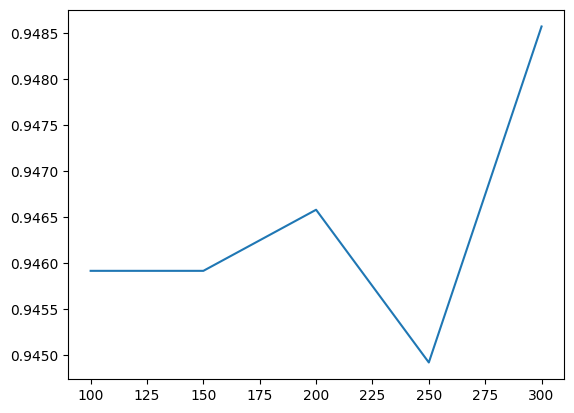

In [40]:
print(acc_fi)
plt.plot(x,acc_fi)

In [5]:
# Purpose completed. No need to run again

# This will help us choose the hyperparameters for our models using Cross Validation
new_df = df.copy()

df1 = Feature_Engineering(new_df)
df2 = df1.copy()

# For 1st model, we convert relevant columns as "not other"
df1.loc[df["field"] != "OTHER", "field"] = 'NOT_OTHER'
X1,y1 = X_y_split(df1)
rus = RandomUnderSampler(random_state=0, sampling_strategy = 0.5)
resampled_X1, resampled_y1 = rus.fit_resample(X1,y1)
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(resampled_X1, resampled_y1, test_size = 0.2)

# For 2nd model, we simply drop all rows with 'OTHER' as label
df2 = df2.loc[df2['field'] != 'OTHER']
X2,y2 = X_y_split(df2)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y2, test_size = 0.2)
# Purpose completed. No need to run again

# Complete dataset
# n_estimators = 250
plot_y = []
for i in [100,150,200,250,300]:
        model = RandomForestClassifier(n_estimators = i)
        cv_score = Cross_Validation(resampled_X1,resampled_y1, model)

        plot_y.append(np.mean(cv_score)*100)

        # Print the output.
        print('iteration value: ', i)
        print('\nAverage Accuracy That can be obtained from this model is:',
        plot_y[-1], '%')

# Filtered dataset
# n_estimators = 250
plot_y = []
for i in [50,100,150,200,250,300]:
        model = RandomForestClassifier(n_estimators = i)
        cv_score = Cross_Validation(X2,y2, model)

        plot_y.append(np.mean(cv_score)*100)

        # Print the output.
        print('iteration value: ', i)
        print('\nAverage Accuracy That can be obtained from this model is:',
        plot_y[-1], '%')